# Preprocessing with FeatureUnion example

The easyflow.preprocessing module contains functionality similar to what sklearn does with its Pipeline, FeatureUnion and ColumnTransformer does. 

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Normalization, IntegerLookup, StringLookup
from keras.utils.vis_utils import plot_model

/Users/fernando/miniforge3/envs/data-science/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
# local imports
from easyflow.data.mapper import TensorflowDataMapper
from easyflow.preprocessing.pipeline import Pipeline, FeatureUnion
from easyflow.preprocessing.custom import NumericPreprocessingLayer

## Read in data and map as tf.data.Dataset

Use the TensorflowDataMapper class to map pandas data frame to a tf.data.Dataset type

In [4]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)
labels = dataframe.pop("target")

batch_size = 32
dataset_mapper = TensorflowDataMapper() 
dataset = dataset_mapper.map(dataframe, labels)
train_data_set, val_data_set = dataset_mapper.split_data_set(dataset)
train_data_set = train_data_set.batch(batch_size)
val_data_set = val_data_set.batch(batch_size)

In [5]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal


## Set constants

In [6]:
NUMERICAL_FEATURES = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope']
CATEGORICAL_FEATURES = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca']
# thal is represented as a string
STRING_CATEGORICAL_FEATURES = ['thal']

## Setup Preprocessing layer using FeatureUnion

Use Encoder and SequentialEncoder to preprocess features by putting everything in a FeatureUnion object

In [10]:
feature_encoder_list = [
    ('numeric_encoder', Normalization(), NUMERICAL_FEATURES),
    ('categorical_encoder', IntegerLookup(output_mode='binary'), CATEGORICAL_FEATURES),
    # For feature thal we first need to run StringLookup followed by a IntegerLookup layer
    ('string_encoder', [StringLookup(), IntegerLookup(output_mode='binary')], STRING_CATEGORICAL_FEATURES)
]

In [1]:
#encoder = FeatureUnion(feature_encoder_list)

NameError: name 'encoder' is not defined

In [11]:
encoder = FeatureUnion(feature_encoder_list)
all_feature_inputs, preprocessing_layer = encoder.encode(dataset)

## Visualize Preprocessing Graph

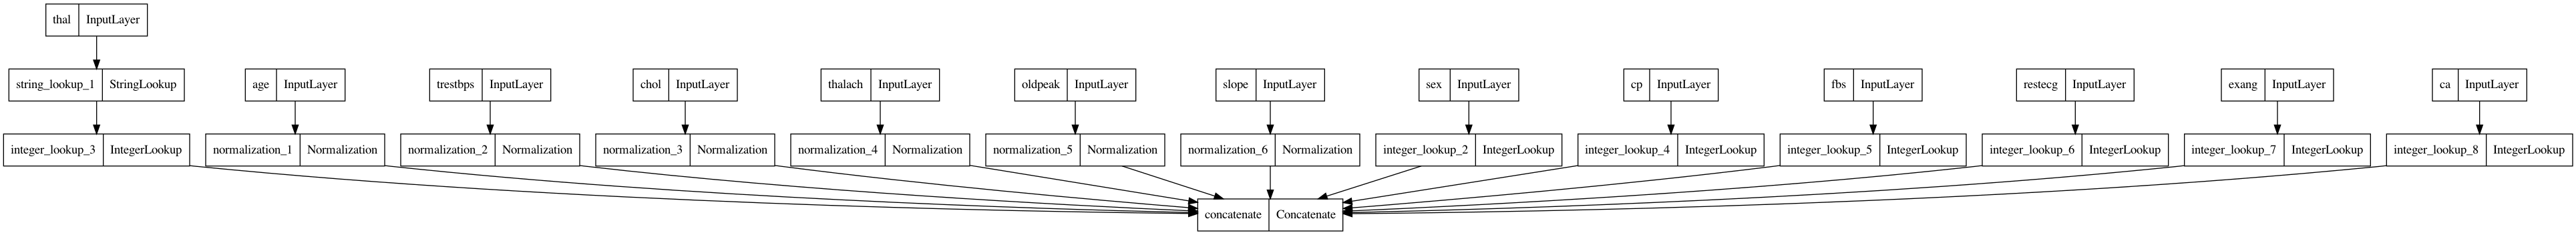

In [16]:
preprocessing_graph = tf.keras.Model(
    inputs = all_feature_inputs,
    outputs = preprocessing_layer
)
plot_model(preprocessing_graph, to_file="preprocessing_graph.png")

## Compile and Train model

In [17]:
# setup simple network
x = tf.keras.layers.Dense(128, activation="relu")(preprocessing_layer)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=all_feature_inputs, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.AUC(name='auc')])

In [18]:
history=model.fit(train_data_set, validation_data=val_data_set, epochs=10)

Epoch 1/10
8/8 [==============================] - 1s 28ms/step - loss: 0.7411 - accuracy: 0.4714 - auc: 0.3933 - val_loss: 0.6053 - val_accuracy: 0.6842 - val_auc: 0.5693
Epoch 2/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5873 - accuracy: 0.7269 - auc: 0.6008 - val_loss: 0.5122 - val_accuracy: 0.7237 - val_auc: 0.8558
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5294 - accuracy: 0.7401 - auc: 0.7234 - val_loss: 0.4338 - val_accuracy: 0.7895 - val_auc: 0.8990
Epoch 4/10
8/8 [==============================] - 0s 2ms/step - loss: 0.5117 - accuracy: 0.7445 - auc: 0.7712 - val_loss: 0.4680 - val_accuracy: 0.7237 - val_auc: 0.8745
Epoch 5/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4747 - accuracy: 0.7445 - auc: 0.8380 - val_loss: 0.4404 - val_accuracy: 0.7632 - val_auc: 0.8687
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: 0.3932 - accuracy: 0.8150 - auc: 0.8957 - val_loss: 0.2936 - val_accuracy: 0.89

## Save and Load model

Save and load model setup with FeatureUnion

In [19]:
model.save('simple_model')
del model

2022-03-19 09:22:50.353024: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: simple_model/assets


In [20]:
loaded_model = tf.keras.models.load_model("simple_model")

In [21]:
loaded_model.predict(val_data_set.take(1))

array([[0.09152788],
       [0.76457435],
       [0.09830472],
       [0.26822647],
       [0.49198335],
       [0.07550076],
       [0.23128602],
       [0.69538397],
       [0.21248144],
       [0.46422634],
       [0.2136243 ],
       [0.24350351],
       [0.17488372],
       [0.11192635],
       [0.09826308],
       [0.00916186],
       [0.59851813],
       [0.6523433 ],
       [0.04309928],
       [0.24652424],
       [0.21918547],
       [0.7613846 ],
       [0.06670126],
       [0.5774843 ],
       [0.6827034 ],
       [0.06425777],
       [0.07975969],
       [0.4023932 ],
       [0.01012573],
       [0.07893661],
       [0.04679602],
       [0.5309296 ]], dtype=float32)